In [1]:
import sys
sys.path.append("../../../")

from utils.misc import select_cuda_device
device = select_cuda_device()

Selected device 2, which has 10820 MB available.


In [2]:
import torch

import numpy as np

import matplotlib.pyplot as plt

from einops import rearrange

from hydra import initialize, compose
from hydra.utils import instantiate

from smc.images import ImageModel, M71ImageModel

In [3]:
with initialize(config_path=".", version_base=None):
    cfg = compose(config_name="config")

---

**Gaussian PSF (default in `ImageModel`):**

In [4]:
image_model = ImageModel(image_height = 25,
                         image_width = 25,
                         background = 491.5867919921875,
                         psf_stdev = 1.9273269405185427)

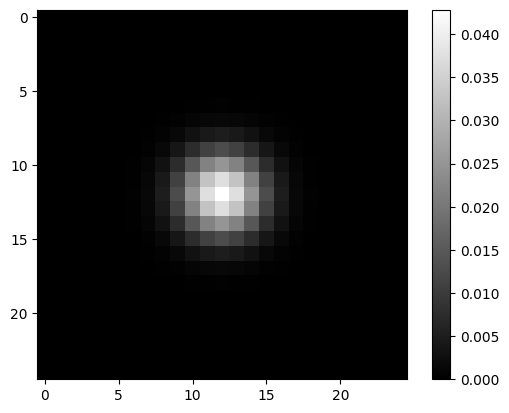

In [5]:
locs = torch.zeros([1,1,1,1,2])
locs[...,0,:] = torch.tensor([12.5, 12.5])

gaussian_psf = image_model.psf(locs).squeeze()

_ = plt.imshow(gaussian_psf, cmap = 'gray')
_ = plt.colorbar()

**SDSS PSF (rasterized):**

In [6]:
sdss = instantiate(cfg.surveys.sdss)
sdss.prepare_data()

In [7]:
sdss_psf = sdss.psf.psf_galsim[sdss.image_id(0)][2].original.image.array

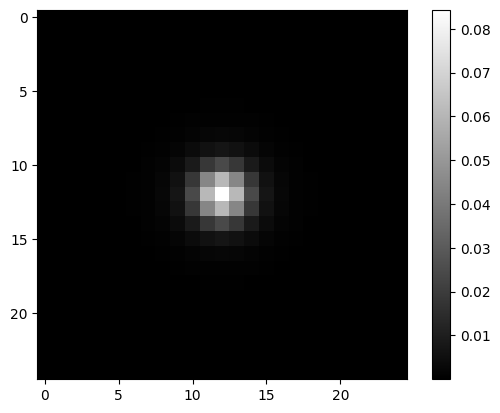

In [8]:
_ = plt.imshow(sdss_psf, cmap = 'gray')
_ = plt.colorbar()

**SDSS PSF (model-based, with a Gaussian core and a power-law wing):**

In [9]:
m71_image_model = M71ImageModel(image_height = sdss_psf.shape[0],
                                image_width = sdss_psf.shape[1],
                                background = sdss[0]['background'][2].mean(),
                                flux_calibration = sdss[0]['flux_calibration'][2].mean(),
                                psf_params = sdss.psf.psf_params[sdss.image_id(0)][2])

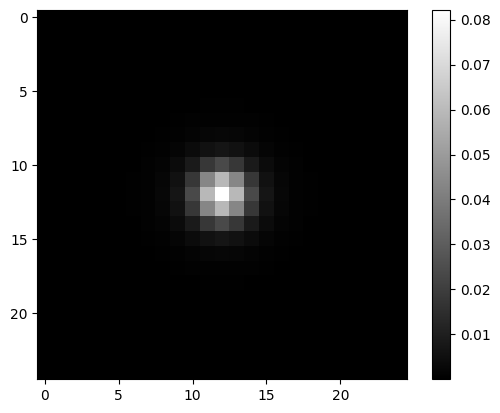

In [10]:
sdss_psf2 = m71_image_model.psf(locs).squeeze()
_ = plt.imshow(sdss_psf2, cmap = 'gray')
_ = plt.colorbar()

**Compare the two SDSS PSFs:**

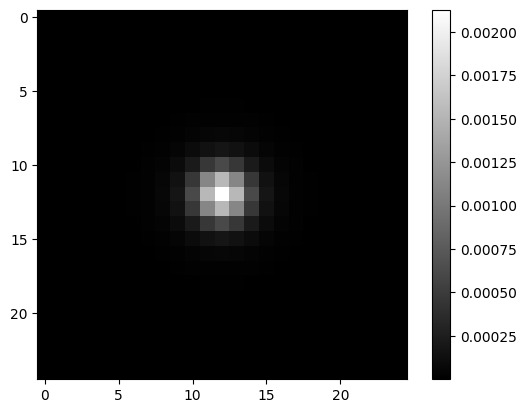

In [11]:
_ = plt.imshow(sdss_psf - sdss_psf2.numpy(), cmap = 'gray')
_ = plt.colorbar()